In [ ]:
# default_exp gbe.ema_drinking

# EMA drinking

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
ist = ist_scoring.get_oversampling_predicted_joint(df)[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#ist = ist.groupby('participant').mean()
ist = ist.rename(columns = {"oversampling_predicted_joint":"ist_oversampling"})

### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_perc_correct_predicted_sep_trial(df)[0]
wm = wm.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
wm = wm.rename(columns={'perc_predicted_sep_trial_no_distractor_1': 'wm_no_1',
                       'perc_predicted_sep_trial_no_distractor_2': 'wm_no_2',
                       'perc_predicted_sep_trial_encoding_distractor': 'wm_encoding',
                       'perc_predicted_sep_trial_delayed_distractor':'wm_delayed'})

5 participants used an old version of the task in some of their sessions.  19 sessions (0.82%) were removed from the dataset.
28 sessions (1.22%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
rtt = rtt_scoring.get_perc_gamble_predicted_joint(df)[0]
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
rtt = rtt.rename(columns={'perc_gamble_joint_win': 'rtt_win',
                       'perc_gamble_joint_loss': 'rtt_loss',
                       'perc_gamble_joint_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and (is_baseline==False)")
sst = sst_scoring.get_ssrt_predicted_joint(df)[0]
sst = sst.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
sst = sst.rename(columns = {'ssrt_predicted_joint':'ssrt'})

### Drinking

In [ ]:
initial_participants = dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']).query("is_initial").participant.unique()
len(initial_participants)

300

### AUD criteria

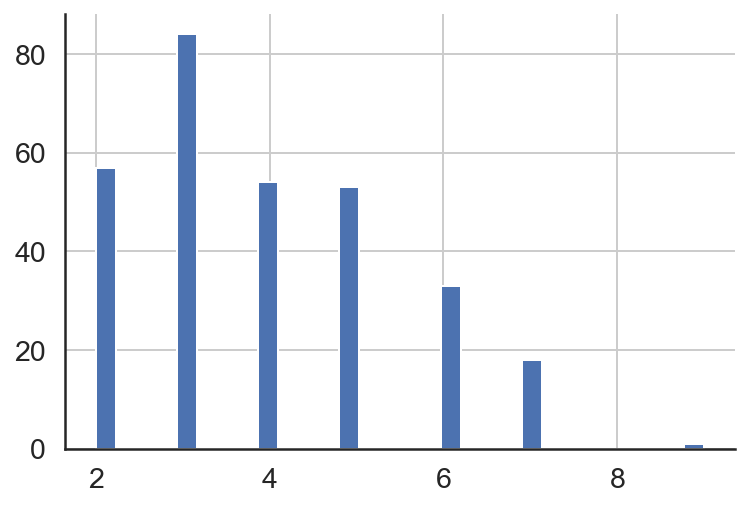

In [ ]:
ba = dp.get_ba_data(columns = ['redcap_event_name','mov_id','bx_aud_sum']).query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
ba = ba[ba.mov_id.isin(initial_participants)]
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud.groupby('participant').first()
aud.aud.hist(bins = 30)
sns.despine()

### Drinking days
16 participants did not report to drink any alcohol during the first EMA month.

In [ ]:
two_day = dp.get_two_day_data()
#drinking_days = two_day.query("sampling_day<30")#.groupby('participant').g_alc.agg(['mean','median'])
#drinking_days['drinking_days'] = ema_drinking.g_alc>0
#drinking_days = drinking_days.groupby('participant')[['g_alc','drinking_days']].sum().reset_index()
#drinking_days = drinking_days[drinking_days.participant.isin(initial_participants)].set_index('participant')

In [ ]:
tasks = pd.concat([wm, sst, rtt,ist],axis = 1).dropna()
tasks = tasks.loc[:,~tasks.columns.duplicated()]

In [ ]:
df = tasks.merge(dp.get_gbe_data(columns = ['trigger_date','time_since_last_gbe','ema_session']), on = 'gbe_index', how = 'left')

<AxesSubplot:>

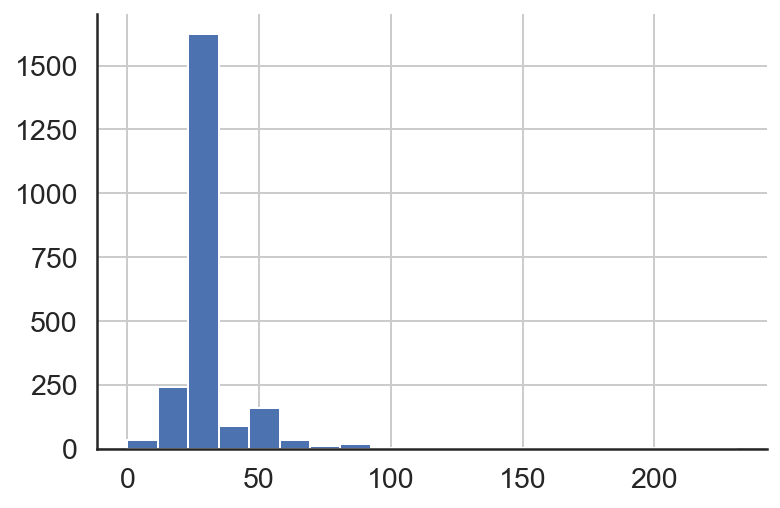

In [ ]:
df.time_since_last_gbe.hist(bins = 20)

> The distance between sessions is mostly 28 days. Some distances are longer (probably due to skipped sessions). Very few are, however also mach shorter.

In [ ]:
df['time_to_next_gbe'] = df.time_since_last_gbe.shift(-1)
# Send maximum to 28 days
df['time_to_next_gbe'][df['time_to_next_gbe'] >= 28] = 28
df.time_to_next_gbe.fillna(28,inplace = True)

> Here we use the distance to the next session or a maximum of 28 days as the window in which we will aggregate drinking data.

In [ ]:
df['end_date'] = df.trigger_date + pd.to_timedelta(df.time_to_next_gbe, unit = 'd')

In [ ]:
two_day['gbe_index'] = None
# Not pretty but it should work
for s in df[['trigger_date','end_date','participant']].reset_index().iterrows():
    gbe_index = s[1].loc['gbe_index']
    starting_date = s[1].loc['trigger_date']
    end_date = s[1].loc['end_date']
    participant = s[1].loc['participant']
    selection = two_day.query('(participant==@participant) and (date<@end_date) and (date >= @starting_date)').index
    two_day.loc[selection, 'gbe_index'] = gbe_index
    
print(end_date)

2021-08-30 15:47:07


In [ ]:
import numpy as np
drinking = two_day.groupby('gbe_index').agg({'g_alc':[np.mean, np.median]})
drinking.columns = ['_'.join(col).strip() for col in drinking.columns.values]
drinking

,g_alc_mean,g_alc_median
gbe_index,,
b001_003,13.472727,4.0
b001_007,16.266667,1.6
b001_009,7.000000,0.0
b001_011,14.647619,6.4
b001_012,27.660000,18.4
...,...,...
m271_011,NaN,NaN
m271_012,NaN,NaN
m271_013,NaN,NaN


## Correlations

In [ ]:
cor = pd.concat([drinking, tasks], axis = 1).dropna()

In [ ]:
import scipy

def correl(df, corr_func = scipy.stats.pearsonr):
    df_corr = pd.DataFrame() # Correlation matrix
    
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = corr_func(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .05, bonferroni = False, size = (11,9), show_correl = True, corr_func = scipy.stats.pearsonr):
    print(len(analysis_data))

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data, corr_func = corr_func)
    
    #sig = (df_p < alpha).replace({True:"*",False:""})
    
    sig = df_p
    sig.where(sig>=.001).fillna(2)
    sig = sig.where(sig>=.01).fillna(3)
    sig = sig.where(sig>.05).fillna(4)
    sig = sig.where(sig>1).fillna(5)
    sig = sig.replace({2:"***"})
    sig = sig.replace({3:"**"})
    sig = sig.replace({4:"*"})
    sig = sig.replace({5:""})

    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    df_corr_label = df_corr.applymap(lambda x: ('%.2f'%x).replace('0.','.'))
    df_corr_label = df_corr_label + sig
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr_label,fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    #p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

1463


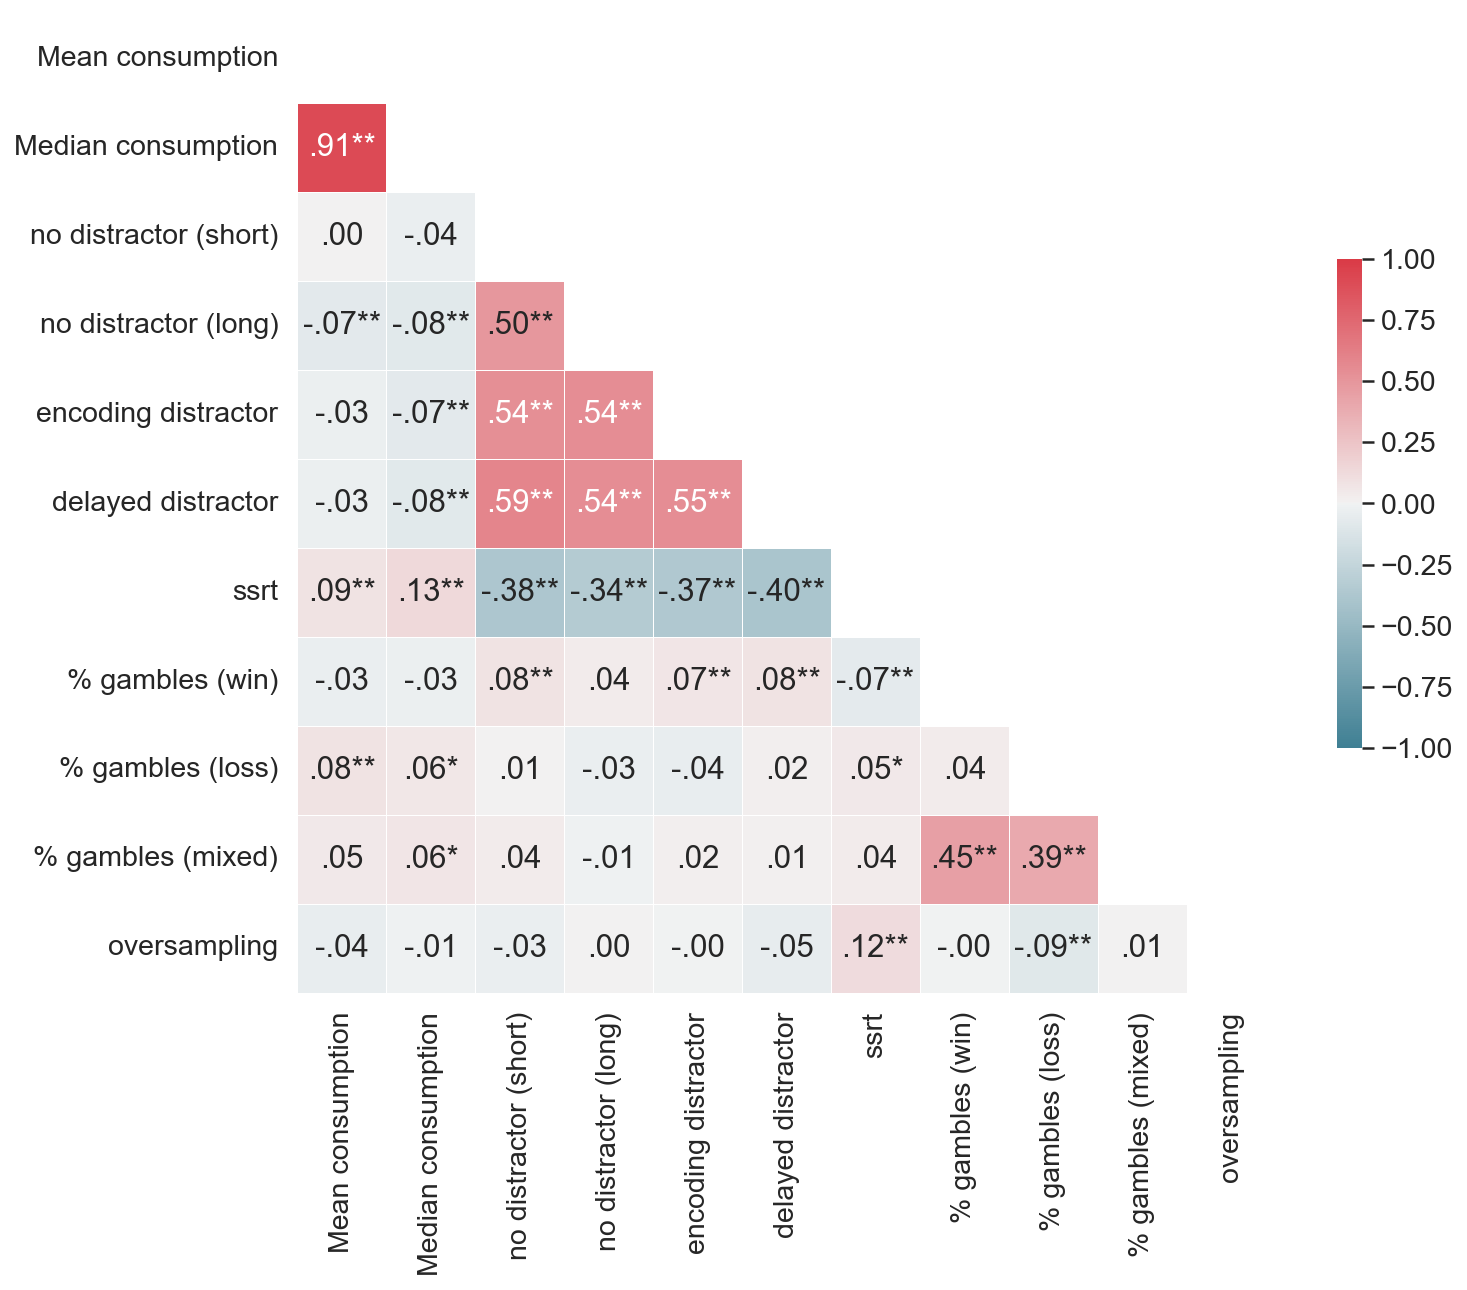

In [ ]:
labels = {
    "wm_no_1":"no distractor (long)",
    "wm_no_2":"no distractor (short)",
    "wm_encoding":"encoding distractor",
    "wm_delayed":"delayed distractor",
    "rtt_win":"% gambles (win)",
    "rtt_loss":"% gambles (loss)",
    "rtt_mixed":"% gambles (mixed)",
    "ist_oversampling":"oversampling",
    "last_three_month":"Drinks per day",
    "g_alc_per_day_last_three_month":"g/alc per day",
    "g_alc_per_drinking_day_last_three_month":"g/alc per drinking day",
    "drinking_days_last_three_month":"Drinking days",
    "aud":"AUD criteria",
    "g_alc_mean":"Mean consumption",
    "g_alc_median":"Median consumption",
    "drinking_days":" Drinking days",
    "g_alc_per_drinking_day":" g/alc per drinking day"
}

cor = cor.rename(columns = labels)    

correlation_matrix(cor.drop(columns = ['participant','session_number']))

<AxesSubplot:>

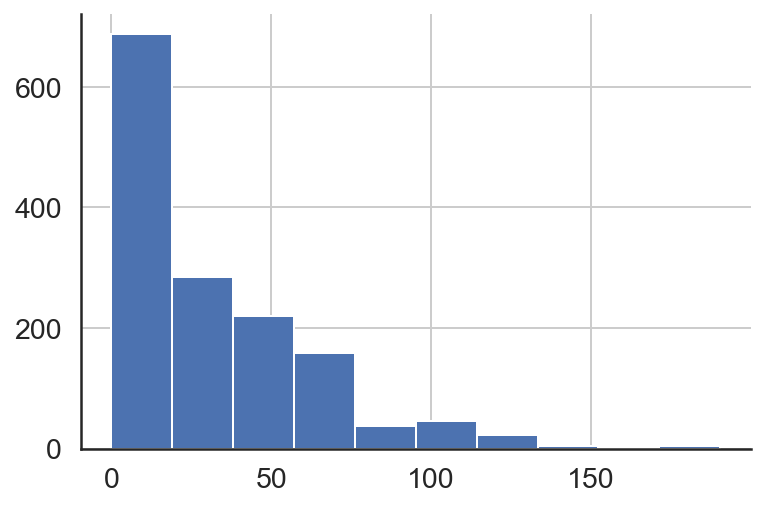

In [ ]:
cor.g_alc_median.hist()

<AxesSubplot:xlabel='ssrt', ylabel='g_alc_median'>

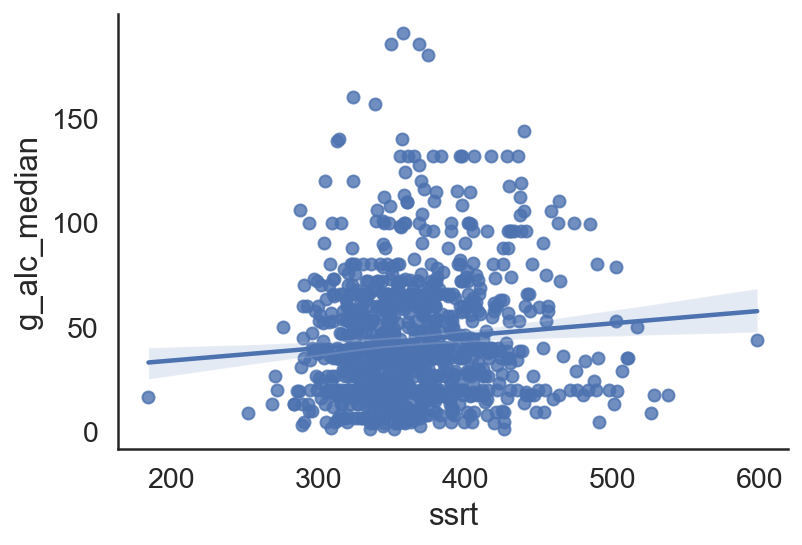

In [ ]:
sns.regplot(x = 'ssrt', y = 'g_alc_median', data = cor_d)

In [ ]:
cor_d = cor.query('g_alc_median>0')

In [ ]:
%%R -i cor_d
require(lmerTest)
m = lmer(g_alc_median ~ ssrt + (1 | participant), data = cor_d)
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_median ~ ssrt + (1 | participant)
   Data: cor_d

REML criterion at convergence: 8622.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0779 -0.4688 -0.0272  0.3796  4.1204 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 702.8    26.51   
 Residual                271.5    16.48   
Number of obs: 962, groups:  participant, 215

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  37.70078    7.50916 959.94772   5.021 6.14e-07 ***
ssrt          0.01156    0.01990 944.82027   0.581    0.561    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
ssrt -0.966


### Based on factors 

In [ ]:
factor_loadings = np.array([[ 7.92661829e-01,  4.78790772e-02,  4.86401575e-03],
       [ 7.63220032e-01, -1.40617072e-02,  3.25907524e-04],
       [ 7.49311048e-01, -2.53512341e-02, -1.37956558e-02],
       [ 8.18257813e-01,  1.04559605e-02, -9.31641296e-03],
       [ 4.63416842e-01, -7.38915150e-02,  1.43192654e-01],
       [ 1.79143311e-02, -2.67090047e-02,  8.60738590e-01],
       [ 7.90922395e-03,  9.98916460e-01, -1.35399086e-02],
       [-1.02745794e-01,  3.35920712e-01,  3.78108731e-01],
       [-7.42983269e-02, -1.32799950e-01, -6.17402248e-02]])

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale

def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores

In [ ]:
tasks_session = tasks.set_index(['participant','session_number'])
tasks_session['ssrt'] = -tasks_session.ssrt

In [ ]:
with open('../data/interim/fa.pkl', 'rb') as f:
    fa = pickle.load(f)

In [ ]:
factor_scores = pd.DataFrame(ten_berge(tasks_session, fa.loadings_))
factor_scores.columns = ['Factor_1','Factor_2','Factor_3']
factor_scores = pd.concat([tasks_session.reset_index(),factor_scores],axis = 1)
factor_scores['gbe_index'] = factor_scores.participant + '_' + factor_scores.session_number.apply(lambda x: '%03d'%int(x))

2229


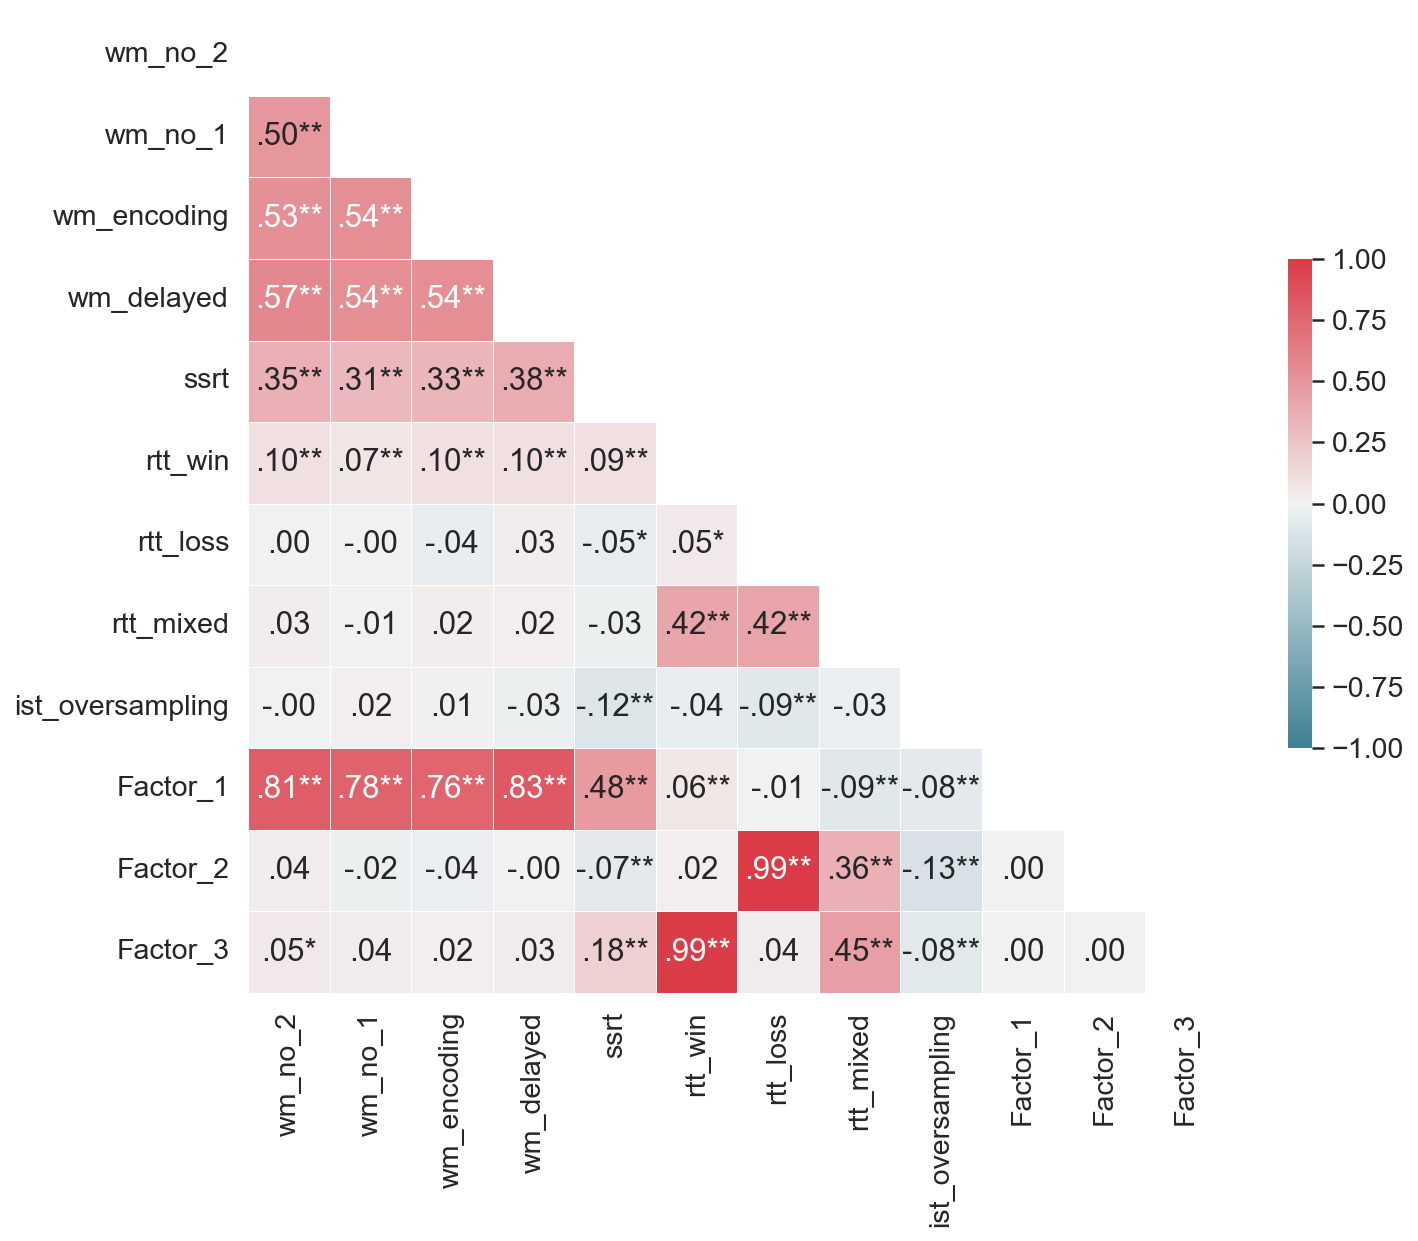

In [ ]:
correlation_matrix(factor_scores.drop(columns = ['participant','session_number','gbe_index']))

In [ ]:
#factor_scores = factor_scores.set_index('gbe_index').filter(like='Factor')
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index').filter(like='Factor')], axis = 1).dropna()

1463


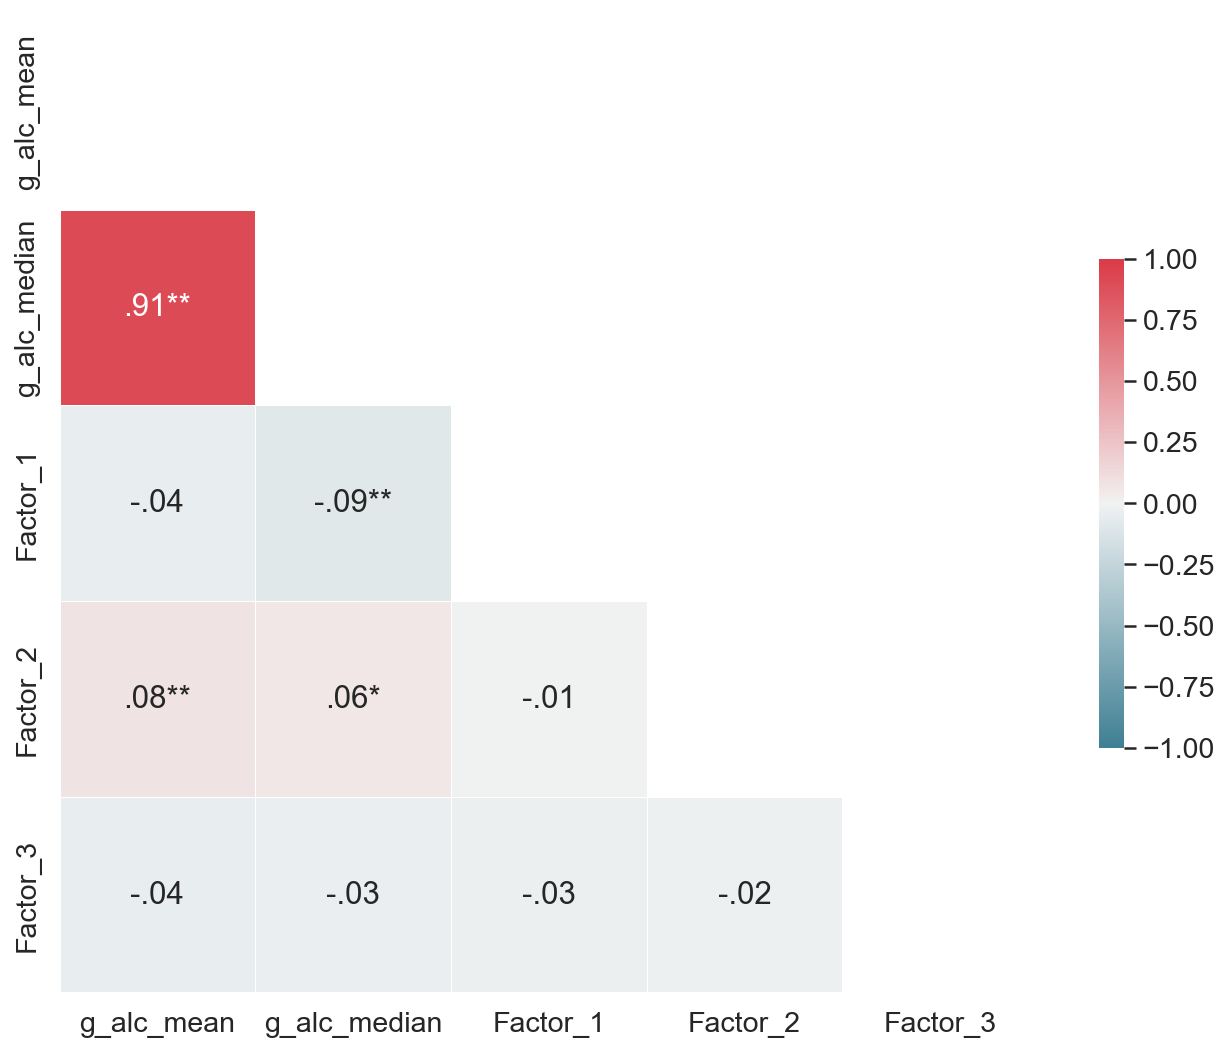

In [ ]:
correlation_matrix(cor2)

In [ ]:
cor2 = pd.concat([drinking, factor_scores.set_index('gbe_index')], axis = 1).dropna()

In [ ]:
%%R -i cor2
require(lmerTest)
m = lmer(g_alc_mean ~ Factor_2 + (1 | participant), data = cor2)
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc_mean ~ Factor_2 + (1 | participant)
   Data: cor2

REML criterion at convergence: 12673.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6160 -0.4537 -0.0686  0.4321  9.2100 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 539.9    23.24   
 Residual                216.5    14.71   
Number of obs: 1463, groups:  participant, 261

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   37.6928     1.5145  250.3339  24.888   <2e-16 ***
Factor_2       0.8372     0.7200 1460.9934   1.163    0.245    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
Factor_2 -0.006


## Hypotheses

- L1. Changes in inhibitory control relate negatively to real-life changes in drinking.
- L2. Changes in risk aversion for gains relate negatively to real-life changes in drinking.
- L3. Changes in risk aversion for losses relate positively to real-life changes in drinking.
- L4. Changes in loss aversion relate negatively to real-life changes in drinking.
- L5. Changes in sampling biases relate negatively to real-life changes in drinking.
- L6. Between-subject differences in working memory moderate the effects of changes in
inhibitory control and risk aversion on changes in drinking. Specifically, the expected positive and negative relationships between changes in inhibitory control as well as in risk aversion (see L1, L2, and L3) and drinking are stronger when working memory is low.
- L7. Between-subject differences in working memory moderate the effects of stress on drinking such that the positive relationship between stress and drinking is stronger when working memory is low.

### ToDo
- Decompose into between- and within-participant effects
- Check pre-registered model (interaction with WM)